<a href="https://colab.research.google.com/github/suyashdamle/deep_learning_projects/blob/master/pytorch_tut.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NOTES:
- Memory is shared between np and torch arrays, after inter-conversions - a change in one reflects in other
- **IMP:  Underscores (' _ ')  represent in-place ops**
-  The first dimension could be keprt the batch_size. Then,
    - W1 : ip_features X n_hidden_1
    - W2 : n_hidden_1 X n_hidden_2 & so on...
- AutoGrad keeps track of outputs of the **leaf nodes only** - in this case, only weights and biases: [look this up](https://towardsdatascience.com/pytorch-autograd-understanding-the-heart-of-pytorchs-magic-2686cd94ec95)
- Be careful with the leaf variables:
  - They should not be overwritten by other objects (ie, ops such as W1 = W1 - lr*grad)
  - In-place ops are NOT allowed over them
  - So, just use the '.data'  notation to replace values during update operations

In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision import datasets, transforms

In [2]:
torch.cuda.get_device_name(0)

'Tesla T4'

# Simple Feed-Forward net from scratch using AutoGrad feature

In [4]:
trainset = datasets.MNIST('data/',download = True, train= True, transform=transforms.ToTensor())                 #convert images to tensors
testset = datasets.MNIST('data/',download = True, train= False, transform=transforms.ToTensor())
loader = torch.utils.data.DataLoader(trainset,batch_size = 100, shuffle=True)
data_iter = iter(loader)

0it [00:00, ?it/s]

9920512it [00:01, 9056570.46it/s]                            


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz


  0%|          | 0/28881 [00:00<?, ?it/s]

32768it [00:00, 135748.48it/s]           
  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 2244510.10it/s]                            
0it [00:00, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz


8192it [00:00, 51017.29it/s]            


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!


torch.Size([100, 1, 28, 28])


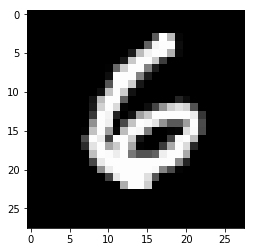

tensor(6)


In [5]:
images,labels = data_iter.next()
print(images.shape)
plt.imshow(images[0].numpy().squeeze(),cmap='gray')
plt.show()
print(labels[0])

In [0]:
# defining the weights
W1 = torch.tensor(np.random.normal(loc = 0., scale=0.01, size=(784,300)),requires_grad=True,dtype=torch.float)
B1 = torch.tensor(np.random.normal(loc = 0., scale=0.01, size=(1,300)),requires_grad = True,dtype=torch.float)

W2 = torch.tensor(np.random.normal(loc = 0., scale=0.01, size=(300,100)), requires_grad=True,dtype=torch.float)
B2 = torch.tensor(np.random.normal(loc = 0., scale=0.01, size=(1,100)),requires_grad = True,dtype=torch.float)

W3 = torch.tensor(np.random.normal(loc = 0., scale=0.01, size=(100,10)), requires_grad=True,dtype=torch.float)
B3 = torch.tensor(np.random.normal(loc = 0., scale=0.01, size=(1,10)),requires_grad = True,dtype=torch.float)


lr = 0.01

In [0]:
def forward_pass(X):
  X = X.view(-1,784)
  h1 = torch.tanh(torch.mm(X,W1)+B1)     # batch_size X n_hidden_1
  h2 = torch.tanh(torch.mm(h1,W2)+B2)    # batch_size X n_hidden_2
  o = torch.tanh(torch.mm(h2,W3)+B3)     # batch_size X n_output
  
  # softmax
  d_r = torch.sum(torch.exp(o),dim=1)    # the denominator: size(50,)
  d_r = d_r.view(-1,1)                   # one sum - per row
  logits = torch.exp(o)/d_r 
  return logits

def backward_pass(logits,y):
  global W1, W2, B1, B2, W3, B3
  
  # --- get cross-entropy loss ---
  
  # convert y into one-hot encodings
  src = torch.ones_like(logits)
  y_one_hot = torch.zeros_like(logits)
  y_one_hot = torch.scatter(y_one_hot,1, y.view(-1,1), src)
  
  # in cross-entropy loss, taking mean of errors of all datapoints in this mini-batch
  loss = -1*(y_one_hot*torch.log(logits) + (1-y_one_hot)*torch.log(1-logits)).sum(1).mean()
  
  # calculate the gradients
  loss.backward()
  
  # update the weights and biases accordingly
  # NOTE: directly using mathematical operations would overwrite variables - they would not be leaves anymore
  # NOTE: leaf variables could not be directly operated upon
  # Using the average of the gradient over the batch

  W1.data = W1.sub(lr*W1.grad.data).data
  B1.data = B1.sub(lr*B1.grad.data).data
  W2.data = W2.sub(lr*W2.grad.data).data
  B2.data = B2.sub(lr*B2.grad.data).data
  W3.data = W3.sub(lr*W3.grad.data).data
  B3.data = B3.sub(lr*B3.grad.data).data
  return  loss

In [39]:
display_step = 1
lr_update_step = 2

for ep in range(10):
  if ep%lr_update_step == 0:
    lr = lr/2.0
  data_iter = iter(loader)                 # resetting the iterator
  for images,labels in data_iter:          # a mini-batch
    logits= forward_pass(images)           # getting the probs
    loss = backward_pass(logits, labels)   # updating weights for this mini-batch
  if ep%display_step == 0:
    print("Epoch # %d: Loss: %f"%(ep, loss.data))
    
# print a sample of labels and predictions to get a feel
print(logits.argmax(dim=1))
print(labels)

Epoch # 0: Loss: 2.122714
Epoch # 1: Loss: 1.891296
Epoch # 2: Loss: 1.903538
Epoch # 3: Loss: 1.859159
Epoch # 4: Loss: 1.738800
Epoch # 5: Loss: 1.771342
Epoch # 6: Loss: 1.927214
Epoch # 7: Loss: 1.840003
Epoch # 8: Loss: 1.756873
Epoch # 9: Loss: 1.623204
tensor([4, 9, 0, 2, 9, 8, 4, 3, 0, 6, 8, 1, 0, 6, 1, 4, 8, 3, 5, 0, 1, 3, 0, 0,
        6, 9, 1, 9, 1, 6, 1, 1, 6, 6, 6, 4, 5, 9, 4, 8, 9, 2, 1, 1, 4, 9, 9, 8,
        8, 3, 9, 9, 1, 2, 1, 1, 6, 9, 5, 2, 4, 5, 8, 3, 4, 5, 1, 2, 1, 0, 1, 1,
        1, 8, 2, 5, 0, 1, 8, 2, 7, 1, 6, 4, 1, 5, 5, 1, 1, 9, 8, 9, 8, 9, 9, 6,
        4, 7, 3, 3])
tensor([4, 7, 0, 2, 4, 8, 4, 3, 0, 6, 8, 1, 2, 6, 1, 4, 8, 3, 5, 0, 1, 3, 0, 0,
        6, 7, 1, 7, 1, 6, 1, 1, 6, 6, 6, 6, 5, 9, 9, 8, 7, 2, 1, 1, 4, 7, 7, 8,
        8, 3, 5, 4, 1, 2, 1, 1, 6, 4, 5, 2, 4, 0, 8, 3, 4, 5, 1, 5, 1, 0, 1, 1,
        1, 8, 3, 5, 0, 1, 8, 2, 1, 1, 6, 4, 1, 5, 3, 1, 1, 7, 8, 4, 8, 7, 7, 6,
        4, 7, 3, 3])


***
# Training Neural Net using the torch.nn and torch.optim API on FashionMNIST

In [0]:
batch_size = 100
trainset = datasets.FashionMNIST('data/',download = True, train= True, transform=transforms.ToTensor())
testset = datasets.FashionMNIST('data/',download = True, train= False, transform=transforms.ToTensor())
loader = torch.utils.data.DataLoader(trainset,batch_size = batch_size, shuffle=True)

torch.Size([100, 1, 28, 28])


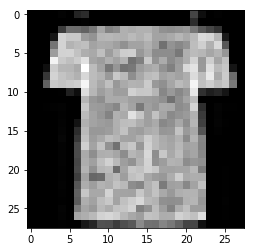

tensor(6)


In [47]:
images,labels = iter(loader).next()
print(images.shape)
plt.imshow(images[0].numpy().squeeze(),cmap='gray')
plt.show()
print(labels[0])

In [0]:
import torch.nn as nn
import torch.optim as optim

In [50]:
# creating a class derived from the module class- supports forward() and backward() itself
model = nn.Sequential(nn.Linear(784,300),
                     nn.ReLU(),
                     nn.Linear(300,100),
                     nn.ReLU(),
                     nn.Linear(100,10),
                     nn.ReLU())

loss_fn= nn.CrossEntropyLoss()
opt = optim.SGD(model.parameters(), lr = 0.01, dampening=0.7)
n_epochs = 10
for ep in range(n_epochs):
  for imgs, labels in loader:
    imgs = imgs.view(batch_size,-1) # reshape the data
    opt.zero_grad()                 # reset gradients
    logits =  model.forward(imgs)   # do forward pass
    loss =  loss_fn(logits, labels) # get loss
    loss.backward()                 # collect gradients in backward pass
    opt.step()                      # update params
  print("Epoch # %d: Loss: %f"%(ep, loss.data))
  
  
# print a sample of labels and predictions to get a feel
print(logits.argmax(dim=1))
print(labels)

Epoch # 0: Loss: 1.688304
Epoch # 1: Loss: 1.059809
Epoch # 2: Loss: 0.736252
Epoch # 3: Loss: 0.742365
Epoch # 4: Loss: 0.867676
Epoch # 5: Loss: 0.768756
Epoch # 6: Loss: 0.615788
Epoch # 7: Loss: 0.770842
Epoch # 8: Loss: 0.664202
Epoch # 9: Loss: 0.648217
tensor([7, 8, 5, 1, 1, 5, 9, 8, 1, 2, 6, 3, 3, 3, 5, 0, 0, 0, 9, 8, 5, 6, 8, 8,
        1, 2, 0, 2, 9, 7, 3, 3, 6, 3, 6, 8, 8, 7, 2, 9, 1, 7, 0, 3, 7, 0, 0, 0,
        2, 9, 2, 5, 0, 6, 5, 6, 5, 3, 6, 5, 7, 7, 9, 7, 0, 5, 3, 6, 3, 0, 2, 8,
        5, 5, 6, 6, 1, 0, 0, 9, 5, 6, 1, 2, 8, 0, 8, 5, 9, 9, 5, 0, 2, 6, 7, 2,
        2, 0, 6, 0])
tensor([7, 8, 5, 1, 1, 5, 9, 8, 1, 2, 2, 3, 3, 3, 7, 6, 6, 0, 4, 8, 5, 2, 8, 8,
        1, 2, 0, 2, 9, 7, 2, 3, 6, 3, 4, 8, 8, 7, 2, 9, 3, 7, 0, 4, 7, 0, 0, 0,
        6, 9, 4, 5, 0, 0, 5, 6, 5, 3, 6, 7, 7, 7, 9, 7, 0, 5, 6, 6, 3, 0, 2, 8,
        5, 5, 6, 6, 1, 3, 0, 9, 5, 4, 1, 4, 8, 6, 8, 5, 9, 9, 5, 0, 2, 4, 7, 2,
        2, 0, 4, 0])
